In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'])


In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_h = sales_h.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_h.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,62686,142038,447509
1,2019-02-01,74426,168635,531319
2,2019-03-01,91347,206976,652116
3,2019-04-01,60600,137309,432617
4,2019-05-01,37374,84683,266809


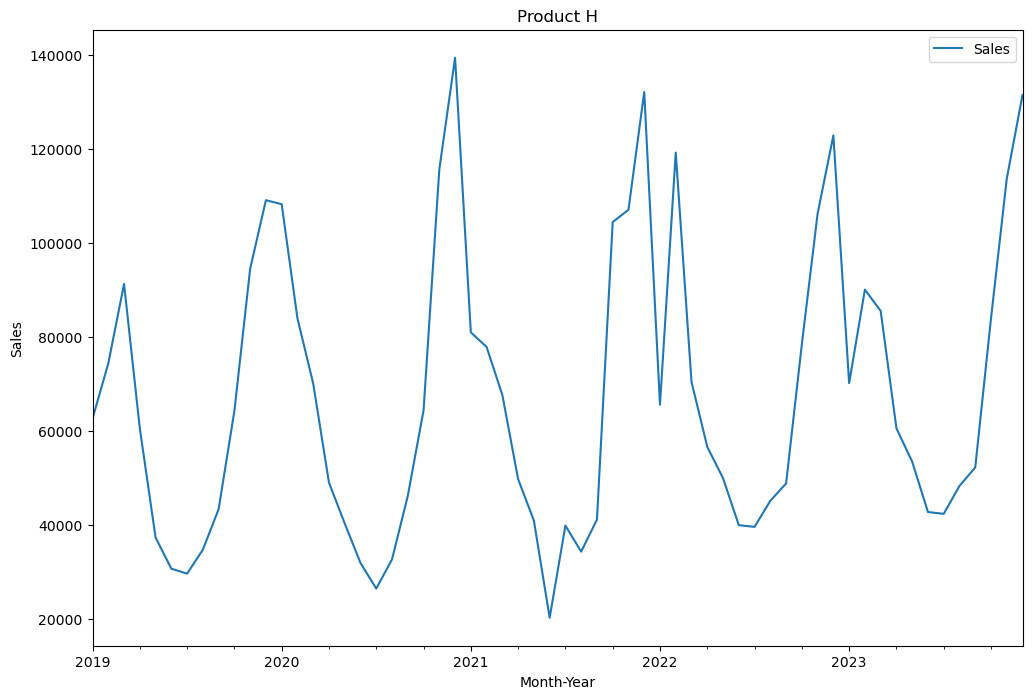

In [5]:
ax = sales_h.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product H')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_h[:54]
test=sales_h[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:33:00 - cmdstanpy - INFO - Chain [1] start processing
00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing
00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing
00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:29 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   14829.135976  
1   16297.676008  
2   15626.432274  
3   14645.796223  
4   16380.930094  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
27,0.100,0.10,multiplicative,14505.939905
15,0.010,0.10,multiplicative,14533.414206
66,0.500,3.00,additive,14536.602550
3,0.001,0.10,multiplicative,14645.796223
0,0.001,0.01,additive,14829.135976
...,...,...,...,...
58,0.300,10.00,additive,20396.079977
51,0.300,0.10,multiplicative,22027.625329
64,0.500,1.00,additive,23012.772900
68,0.500,5.00,additive,23594.008395


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, seasonality_mode='multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

00:46:01 - cmdstanpy - INFO - Chain [1] start processing
00:46:01 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_h['Market Size']
future_dates['Marketing Expense'] = sales_h['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,142038,447509
1,2019-02-01,168635,531319
2,2019-03-01,206976,652116
3,2019-04-01,137309,432617
4,2019-05-01,84683,266809
5,2019-06-01,69648,219428
6,2019-07-01,67255,211904
7,2019-08-01,78824,248348
8,2019-09-01,98356,309885
9,2019-10-01,214290,675154


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,35618.387401,21008.611140,49963.492520
55,2023-08-01,40094.654092,25770.517897,55692.837234
56,2023-09-01,45379.701214,30670.222078,59713.161391
57,2023-10-01,72179.493564,57766.568136,86057.911726
58,2023-11-01,98368.068776,83381.435735,113574.609441
59,2023-12-01,124594.896168,110249.933180,138383.111441


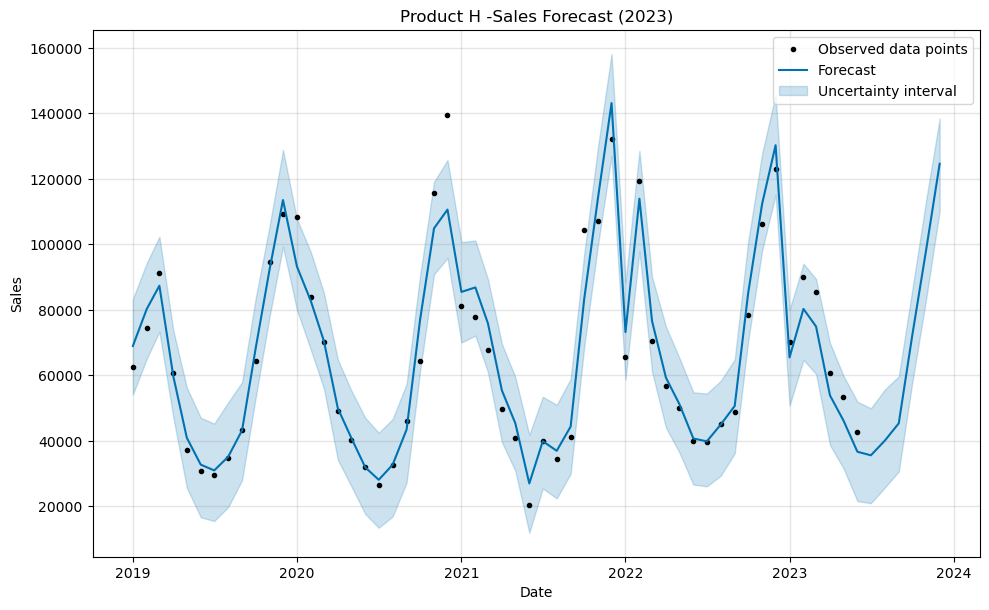

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product H -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

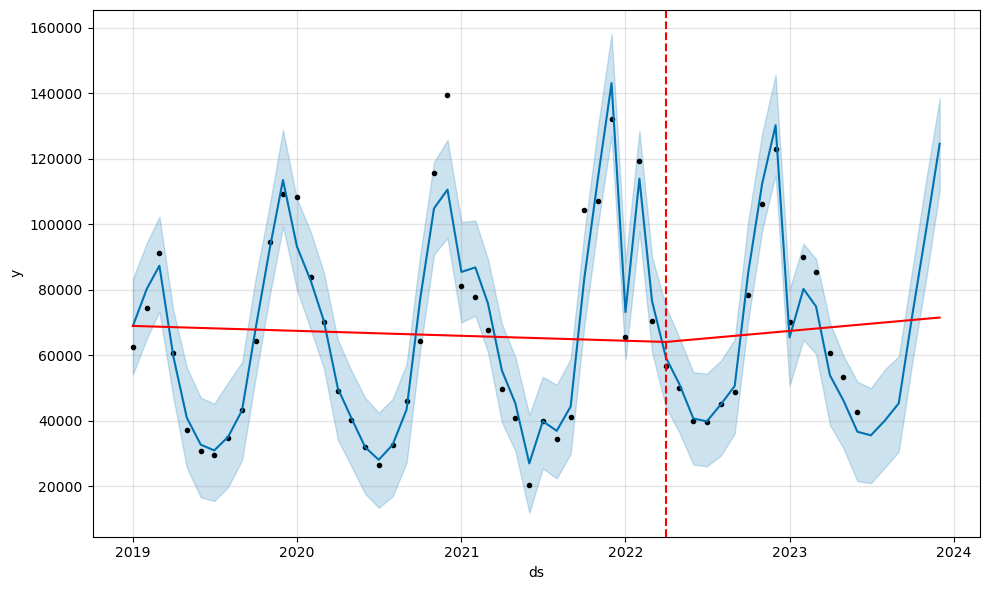

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

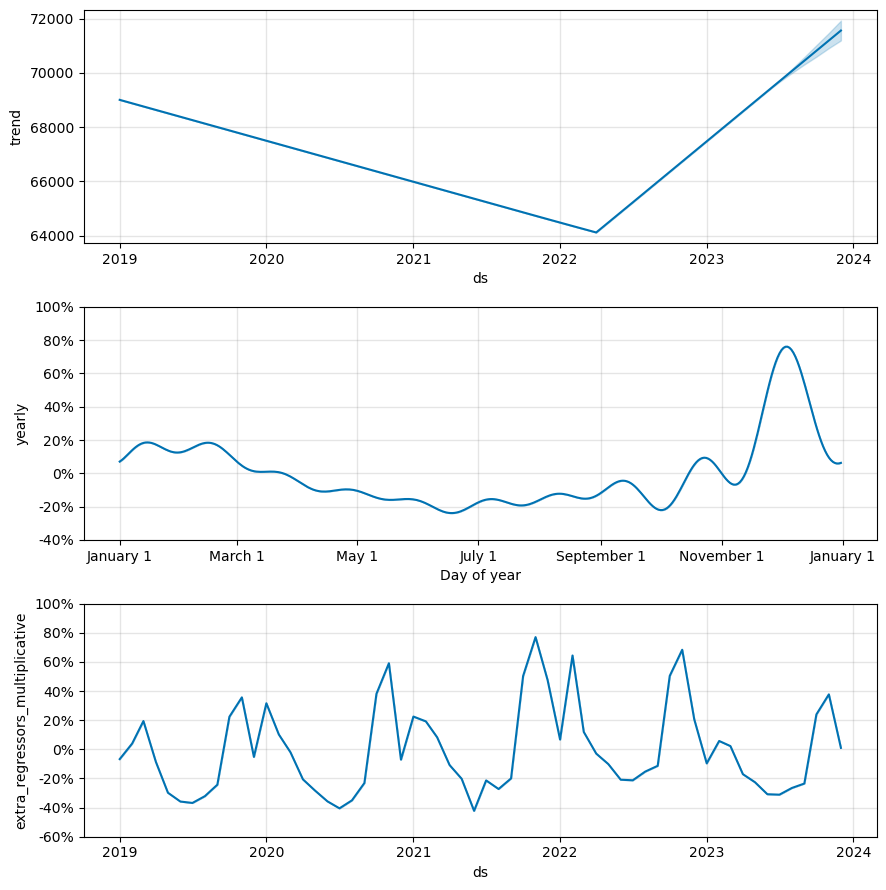

In [21]:
fig2 = model.plot_components(forecast)

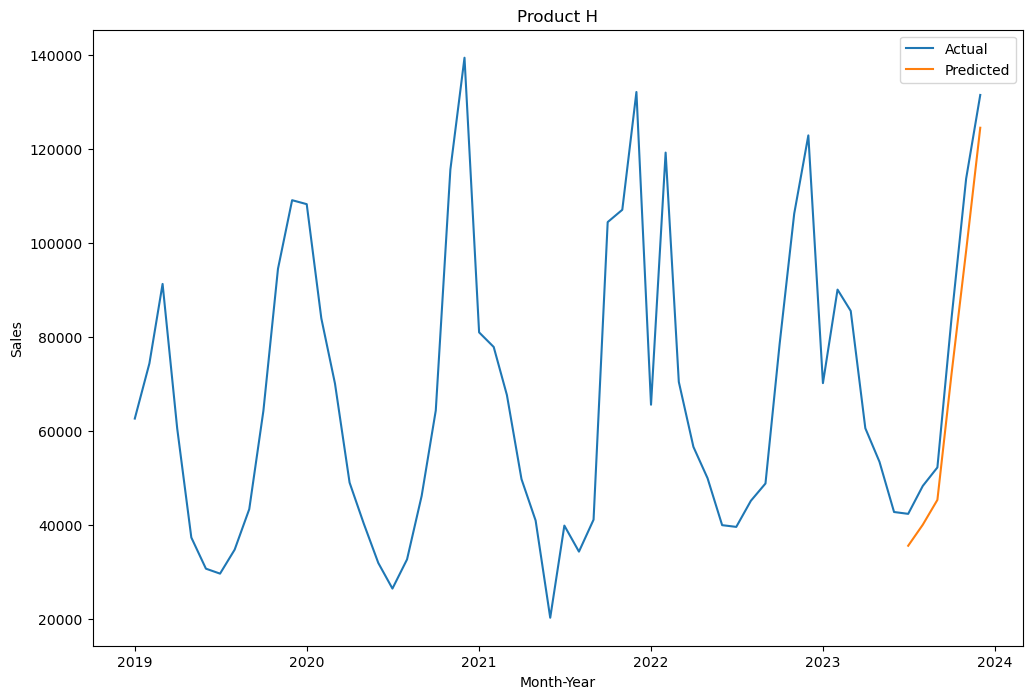

In [22]:
# Reset index of sales_b DataFrame
sales_h_reset_index = sales_h.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_h_reset_index['ds'], sales_h_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product H')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 9357.466
MAPE - FB PROPHET: 0.132
MSE - FB PROPHET: 97864682.959
RMSE - FB PROPHET: 9892.658


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,1.991894e+07,4463.063795,3641.624152,0.060694,0.060694,0.062877,1.0
1,25 days,2.419657e+07,4919.001163,4666.703896,0.086650,0.086650,0.090612,1.0
2,29 days,2.135260e+08,14612.530425,11770.604613,0.184699,0.184699,0.211057,0.5
3,51 days,2.116269e+08,14547.402885,11427.629977,0.180735,0.180735,0.204286,0.5
4,55 days,1.967491e+08,14026.729260,11056.775110,0.117803,0.117803,0.124020,0.5
5,56 days,2.017748e+08,14204.747128,11839.901629,0.126680,0.126680,0.136142,0.5
6,60 days,4.068059e+08,20169.430109,16117.522098,0.200833,0.200833,0.231977,0.5
7,82 days,4.042934e+08,20107.048546,15773.102262,0.196781,0.196781,0.224337,0.5
8,83 days,3.661720e+07,6051.215076,5598.805881,0.096111,0.096111,0.097885,1.0
9,87 days,3.754124e+07,6127.090830,5733.213772,0.092541,0.092541,0.097248,1.0


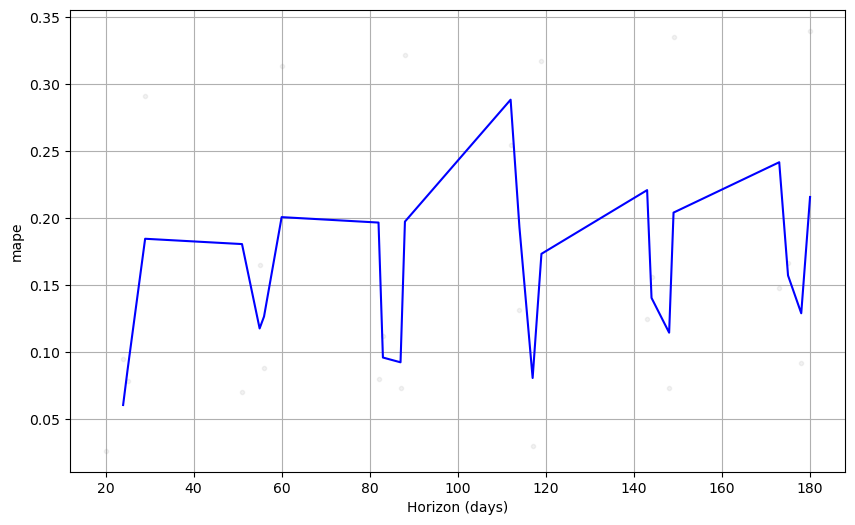

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54     42408
55     48352
56     52288
57     84019
58    113741
59    131572
Name: y, dtype: int64

In [30]:
pred

54     35618.387401
55     40094.654092
56     45379.701214
57     72179.493564
58     98368.068776
59    124594.896168
Name: yhat, dtype: float64